# Anomaly Detection Exercises

In [1]:
from __future__ import division

import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from numpy import linspace, loadtxt, ones, convolve
from sklearn.ensemble import IsolationForest

import numpy as np
import pandas as pd
import collections
import math

from sklearn import metrics
from random import randint
from matplotlib import style

import seaborn as sns

style.use('fivethirtyeight')
%matplotlib inline

pd.set_option('display.max_rows', 50000)

In [2]:
def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()    

# Discrete data + probability

> Use basic probability to identify anomalous request methods. You will want to make sure the text is normalized in order to reduce the noise.

In [3]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']

df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [4]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
ip                13978 non-null object
timestamp         13978 non-null object
request_method    13978 non-null object
status            13978 non-null int64
size              13978 non-null int64
destination       25 non-null object
request_agent     13978 non-null object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


In [6]:
df.timestamp = df.timestamp.str.replace('[', '')
df.timestamp = df.timestamp.str.replace(']', '')
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
df = df.set_index('timestamp')

In [7]:
df.tail()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-17 12:55:14,97.105.19.58,"""GET /api/v1/sales?page=71 HTTP/1.1""",200,510166,NaN,"""python-requests/2.21.0"""
2019-04-21 10:02:41,95.31.18.119,GET /api/v1/items/HTTP/1.1,200,1153005,NaN,python-requests/2.21.0
2019-04-17 19:36:41,95.31.16.121,GET /api/v1/sales?page=79/HTTP/1.1,301,1005,NaN,python-requests/2.21.0
2019-04-18 19:42:41,97.105.15.120,GET /api/v1/sales?page=79/HTTP/1.1,301,2560,NaN,python-requests/2.21.0
2019-04-19 19:42:41,97.105.19.58,GET /api/v1/sales?page=79/HTTP/1.1,200,2056327,NaN,python-requests/2.21.0


In [8]:
df.request_method = df.request_method.str.replace('"', '')
df.request_agent = df.request_agent.str.replace('"', '')
df.destination = df.destination.str.replace('"', '')

df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [9]:
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [10]:
df.describe()

,status,size,size_mb
count,13978.000000,1.397800e+04,13978.000000
mean,200.356703,4.500019e+05,0.429155
std,10.182001,1.614915e+05,0.154010
min,200.000000,0.000000e+00,0.000000
25%,200.000000,5.006370e+05,0.477445
50%,200.000000,5.101380e+05,0.486506
75%,200.000000,5.112910e+05,0.487605
max,499.000000,2.056327e+06,1.961066


In [11]:
my_datetime_fmt = mdates.DateFormatter('%m-%d %H:%T')

df_ts_size = df['size_mb'].resample('30T').median()

idx = pd.date_range(
    df_ts_size.sort_index().index.min(), 
    df_ts_size.sort_index().index.max(),
    freq='30min'
)

df_ts_size = df_ts_size.reindex(idx, fill_value=0).fillna(value=0)

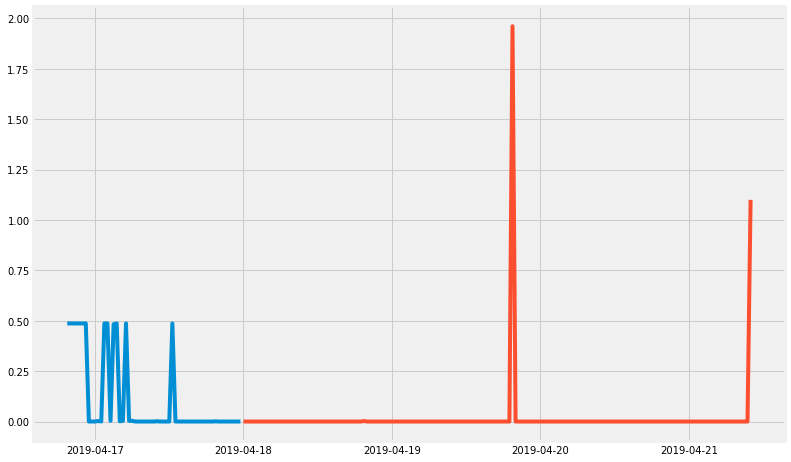

In [12]:
start_date_train = df_ts_size.head(1).index[0]
end_date_train = '2019-04-17 23:59:00'
start_date_test = '2019-04-18 00:00:00'

train = df_ts_size[:end_date_train]
test = df_ts_size[start_date_test:]

plt.figure(figsize=(12, 8))
plt.plot(train)
plt.plot(test)
plt.show()

In [13]:
short_rolling = train.rolling(window=12).mean()
long_rolling = train.rolling(window=24).mean()

Text(0, 0.5, 'Size (MB)')

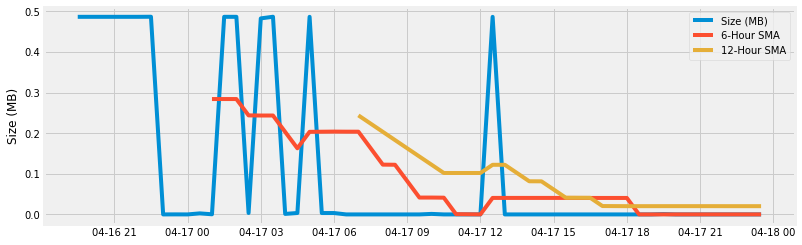

In [14]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(train.index, 
        train,
        label='Size (MB)')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '6-Hour SMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '12-Hour SMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

In [15]:
ema_short = train.ewm(span=12, adjust=False).mean()
ema_short[0:3]

ema_long = train.ewm(span=24, adjust=False).mean()
ema_long[0:3]

2019-04-16 19:30:00    0.486491
2019-04-16 20:00:00    0.486492
2019-04-16 20:30:00    0.486493
Freq: 30T, Name: size_mb, dtype: float64

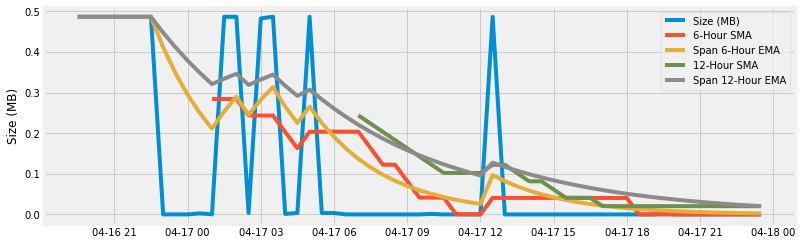

In [16]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(train.index, 
        train,
        label='Size (MB)')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '6-Hour SMA')
ax.plot(long_rolling.index, 
        ema_short, 
        label = 'Span 6-Hour EMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '12-Hour SMA')
ax.plot(long_rolling.index, 
        ema_long, 
        label = 'Span 12-Hour EMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

yhat = pd.DataFrame(dict(actual=test))

In [17]:
yhat['moving_avg_forecast'] = ema_long.iloc[-1]

In [18]:
### compute the absolute error:
yhat['error'] = abs(yhat.actual - yhat.moving_avg_forecast)

### compute upper band and lower band using IQR with weight of 3

q3 = yhat.error.describe().loc['75%']
q1 = yhat.error.describe().loc['25%']

### adding .1 to the IQR so the we don't end up with a denominator of 0. 
ub = q3 + 3*(q3-q1+.1)
lb = q1 - 3*(q3-q1+.1)

yhat['pct_b'] = (yhat.actual-lb)/(ub-lb)

In [19]:
yhat[yhat.pct_b > 1]

,actual,moving_avg_forecast,error,pct_b
2019-04-19 19:30:00,1.961066,0.020349,1.940717,3.734528
2019-04-21 10:00:00,1.099591,0.020349,1.079242,2.298736


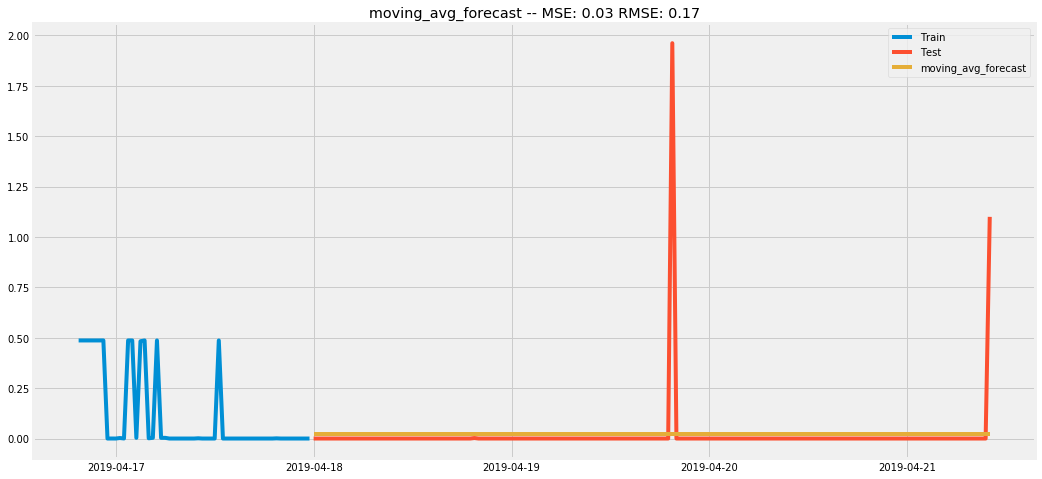

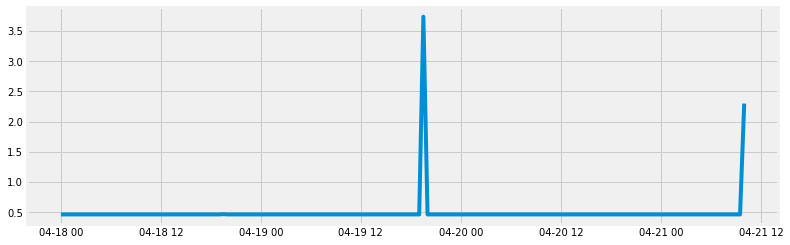

In [20]:
plot_and_eval(yhat.moving_avg_forecast, actual=test)
plt.figure(figsize=(12,4))
plt.plot(yhat.pct_b)

# Detecting Anomalies of Continuous Variables with Time Series Using Statistical Methods

> Discover users who are accessing our curriculum pages way beyond the end of their codeup time. What would the dataframe look like? Use time series method for detecting anomalies, like exponential moving average with %b. 

Bonus
> Can you label students who are viewing both the web dev and data science curriculum? Can you label students by the program they are in? Can you label users by student vs. staff? What is zach's id? What is maggie's id?

In [21]:
colnames=['date','page_viewed','user_id','cohort_id','ip']
df = pd.read_csv('anonymized-curriculum-access.txt',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0,2,3,4,5]
)

df = df.dropna()
df.cohort_id = df.cohort_id.astype('int')

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219070 entries, 0 to 233527
Data columns (total 5 columns):
date           219070 non-null object
page_viewed    219070 non-null object
user_id        219070 non-null int64
cohort_id      219070 non-null int64
ip             219070 non-null object
dtypes: int64(2), object(3)
memory usage: 10.0+ MB


In [23]:
colnames=['cohort_id','cohort_name','start_date','end_date']

In [24]:
df_cohort = pd.read_clipboard(sep=',',names=colnames, skiprows=1)

In [25]:
df = df.merge(df_cohort, on='cohort_id', how='left')
df = df[df.start_date >= '2018-01-26'].reset_index().drop(columns='index')

In [26]:
df['start_date'] = pd.to_datetime(df.start_date)
df['end_date'] = pd.to_datetime(df.end_date)
df['date'] = pd.to_datetime(df.date)
df.head()

,date,page_viewed,user_id,cohort_id,ip,cohort_name,start_date,end_date
0,2018-03-05,html-css/css-i,25,23,97.105.19.61,Ulysses,2018-03-05,2018-07-19
1,2018-03-05,html-css/forms,25,23,97.105.19.61,Ulysses,2018-03-05,2018-07-19
2,2018-03-05,html-css/css-i,25,23,97.105.19.61,Ulysses,2018-03-05,2018-07-19
3,2018-03-05,html-css/css-i/introduction,25,23,97.105.19.61,Ulysses,2018-03-05,2018-07-19
4,2018-03-05,html-css,25,23,97.105.19.61,Ulysses,2018-03-05,2018-07-19


In [27]:
df['days_normalized'] = (df['date']-df['start_date']).dt.days
df = df.groupby(['user_id','cohort_name','days_normalized', 'ip'])['page_viewed'].count().reset_index()

In [28]:
df.head()

,user_id,cohort_name,days_normalized,ip,page_viewed
0,25,Ulysses,0,97.105.19.61,15
1,25,Ulysses,1,97.105.19.61,9
2,25,Ulysses,2,97.105.19.61,56
3,25,Ulysses,3,97.105.19.61,11
4,25,Ulysses,4,70.120.83.9,10


In [29]:
OOP = df['days_normalized'] > 134
df = df[OOP]

In [30]:
df.describe()

,user_id,days_normalized,page_viewed
count,987.000000,987.000000,987.000000
mean,205.619048,200.163121,7.687943
std,67.051695,61.129619,10.173739
min,25.000000,135.000000,1.000000
25%,134.000000,148.000000,2.000000
50%,195.000000,180.000000,4.000000
75%,264.000000,240.000000,9.000000
max,371.000000,389.000000,153.000000


In [31]:
max_entries = df.groupby('cohort_name').max()

In [32]:
max_entries['longitude'] = [-98.4761, -95.3320, -98.6433, -96.7914, -95.3320]
max_entries['latitude'] = [29.3959, 29.6679, 29.4027, 32.9720, 29.6679]

In [33]:
max_entries

,user_id,days_normalized,ip,page_viewed,longitude,latitude
cohort_name,,,,,,
Ulysses,319,389,99.158.247.126,48,-98.4761,29.3959
Voyageurs,278,304,99.203.27.241,72,-95.3320,29.6679
Wrangell,282,248,99.52.75.127,153,-98.6433,29.4027
Xanadu,315,197,98.6.75.74,73,-96.7914,32.9720
Yosemite,371,148,99.203.27.223,36,-95.3320,29.6679


<Figure size 1152x1152 with 0 Axes>

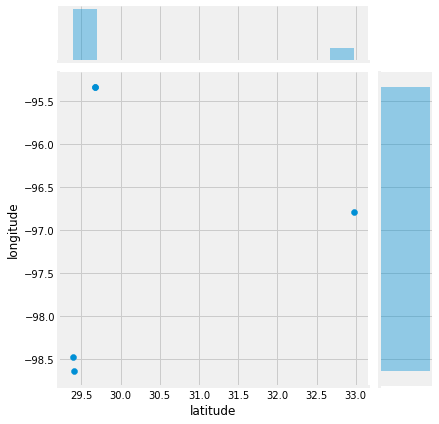

In [34]:
fig = plt.figure(figsize=(16,16))
sns.jointplot(x='latitude', y='longitude', data=max_entries)

# Clustering -DBSCAN  
> Use dbscan to detect anomalies in other products from the customers dataset.  


> Use dbscan to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).

In [35]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [36]:
df = pd.read_csv('Wholesale customers data.csv')
df.columns

Index(['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen'],
      dtype='object')

In [37]:
df = df[['Region', 'Fresh', 'Frozen']]

In [38]:
df.Region.value_counts()

3    316
1     77
2     47
Name: Region, dtype: int64

In [39]:
food_type = df[['Fresh', 'Frozen']]

In [40]:
np_array = food_type.values.astype('float32', copy=False)
np_array[0:5]

array([[12669.,   214.],
       [ 7057.,  1762.],
       [ 6353.,  2405.],
       [13265.,  6404.],
       [22615.,  3915.]], dtype=float32)

In [41]:
stscaler = StandardScaler().fit(np_array)
np_array = stscaler.transform(np_array)
np_array[0:5]

array([[ 0.05293319, -0.5893672 ],
       [-0.39130196, -0.27013618],
       [-0.44702926, -0.13753572],
       [ 0.1001114 ,  0.68714434],
       [ 0.8402394 ,  0.17385884]], dtype=float32)

In [42]:
dbsc = DBSCAN(eps = .75, min_samples = 20).fit(np_array)

In [43]:
labels = dbsc.labels_
labels[0:5]

array([0, 0, 0, 0, 0])

In [44]:
df['labels'] = labels
df.labels.value_counts()

 0    416
-1     24
Name: labels, dtype: int64

**Let's see where the anomalies land**

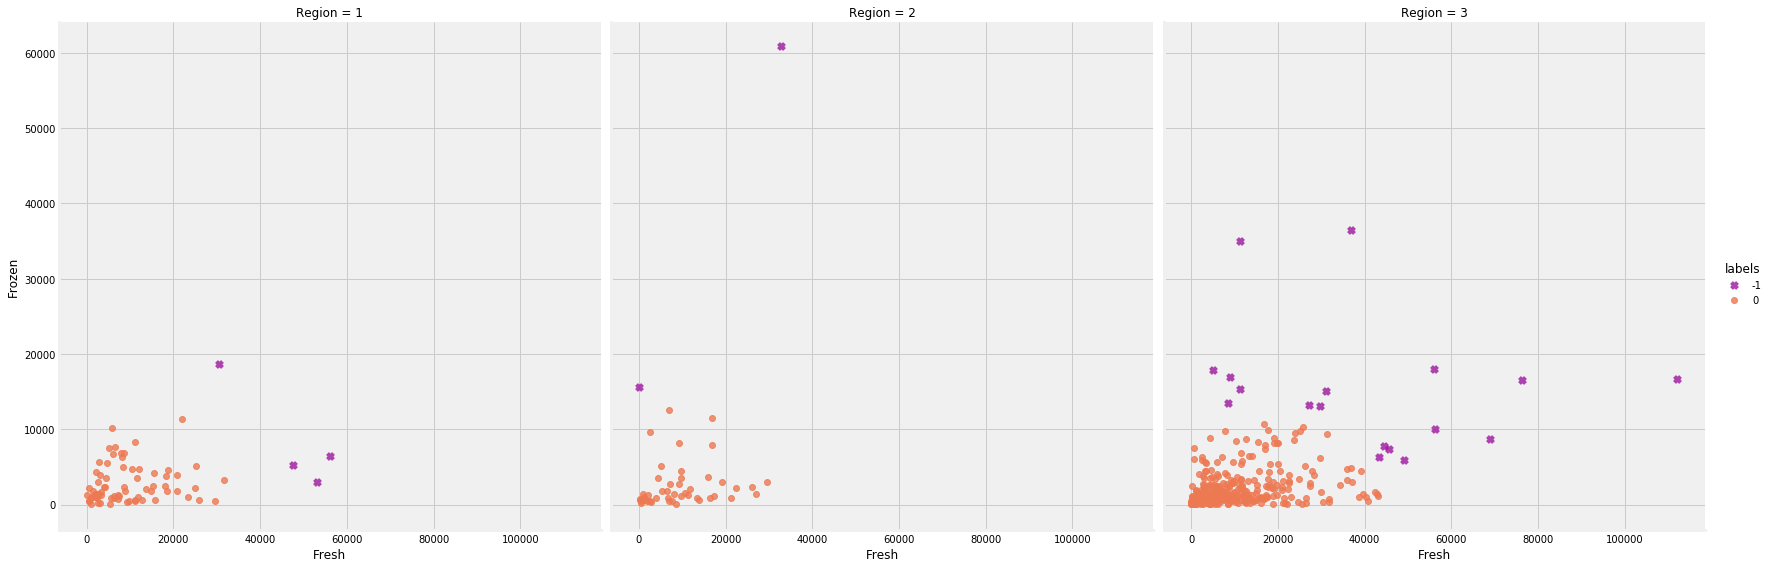

In [45]:
sns.lmplot(x='Fresh', y='Frozen', hue='labels', data=df, fit_reg=False, col='Region', markers=["x", "o"], height=8, palette='plasma')

**Anomalies per region**

In [46]:
df.groupby(df.Region).labels.value_counts()

Region  labels
1        0         73
        -1          4
2        0         45
        -1          2
3        0        298
        -1         18
Name: labels, dtype: int64

# Extra (Titanic Dataset)

In [47]:
import env

def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

def get_titanic_data():
    return pd.read_sql('SELECT * FROM passengers', get_connection('titanic_db'))

In [48]:
dft = get_titanic_data()

In [49]:
dft.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,None,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,None,Southampton,1
3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,0,3,male,35.0,0,0,8.0500,S,Third,None,Southampton,1


In [72]:
dft.rename(columns={'class': 'class_id'}, inplace=True)

dft[['deck']] = dft.deck.fillna(method='ffill')
dft[['age']] = dft.age.fillna(method='ffill')
dft[['embark_town']] = dft.embark_town.fillna(method='ffill')

In [73]:
dft.groupby([('pclass'),('deck')]).agg(['size', 'mean'])

passenger_id             survived            age            sibsp  \
                    size        mean     size      mean size       mean  size   
pclass deck                                                                     
1      A              22  448.772727       22  0.545455   22  37.363636    22   
       B              55  514.254545       55  0.672727   55  34.990909    55   
       C              73  397.821918       73  0.575342   73  35.895068    73   
       D              33  519.303030       33  0.727273   33  40.939394    33   
       E              32  470.968750       32  0.656250   32  38.062500    32   
       F               1   83.000000        1  0.000000    1  28.000000     1   
2      A              14  462.571429       14  0.500000   14  26.000000    14   
       B              32  474.250000       32  0.343750   32  31.072813    32   
       C              55  397.545455       55  0.490909   55  27.945455    55   
       D              25  479.560000       25  0.440000   25  35.800000    25   
       E              33  589.787879       33  0.515152   33  31.732424    33   
       F              20  244.850000       20  0.600000   20  23.816500    20   
       G               5  401.200000        5  0.400000    5  26.800000     5   
3      A              41  452.536585       41  0.268293   41  26.829268    41   
       B             114  478.500000      114  0.289474  114  24.219298   114   
       C             131  367.854962      131  0.167939  131  26.206107   131   
       D              68  471.500000       68  0.264706   68  30.036765    68   
       E              83  561.385542       83  0.228916   83  27.506024    83   
       F              34  260.558824       34  0.323529   34  24.970588    34   
       G              19  332.947368       19  0.263158   19  23.947368    19   

                      parch           fare             alone            \
                 mean  size      mean size        mean  size      mean   
pclass deck                                                              
1      A     0.090909    22  0.090909   22   47.876514    22  0.863636   
       B     0.345455    55  0.490909   55  111.726213    55  0.509091   
       C     0.547945    73  0.397260   73   93.419348    73  0.452055   
       D     0.515152    33  0.333333   33   66.734600    33  0.333333   
       E     0.375000    32  0.250000   32   59.694791    32  0.531250   
       F     0.000000     1  0.000000    1   47.100000     1  1.000000   
2      A     0.428571    14  0.357143   14   21.755657    14  0.571429   
       B     0.500000    32  0.375000   32   20.497006    32  0.531250   
       C     0.290909    55  0.454545   55   20.526136    55  0.581818   
       D     0.440000    25  0.240000   25   19.788168    25  0.520000   
       E     0.454545    33  0.393939   33   20.795327    33  0.575758   
       F     0.400000    20  0.400000   20   22.128540    20  0.600000   
       G     0.400000     5  0.200000    5   17.780000     5  0.600000   
3      A     0.560976    41  0.365854   41   11.393490    41  0.634146   
       B     0.771930   114  0.447368  114   15.173026   114  0.631579   
       C     0.641221   131  0.450382  131   13.885464   131  0.664122   
       D     0.544118    68  0.279412   68   12.549876    68  0.735294   
       E     0.481928    83  0.385542   83   13.687899    83  0.674699   
       F     0.617647    34  0.323529   34   14.225976    34  0.647059   
       G     0.421053    19  0.315789   19   11.495832    19  0.578947   

            deck_cat       
                size mean  
pclass deck                
1      A          22    0  
       B          55    1  
       C          73    2  
       D          33    3  
       E          32    4  
       F           1    5  
2      A          14    0  
       B          32    1  
       C          55    2  
       D          25    3  
       E          33    4  
       F          20    5  
       G           5    6

Text(0.5, 0, 'Deck')

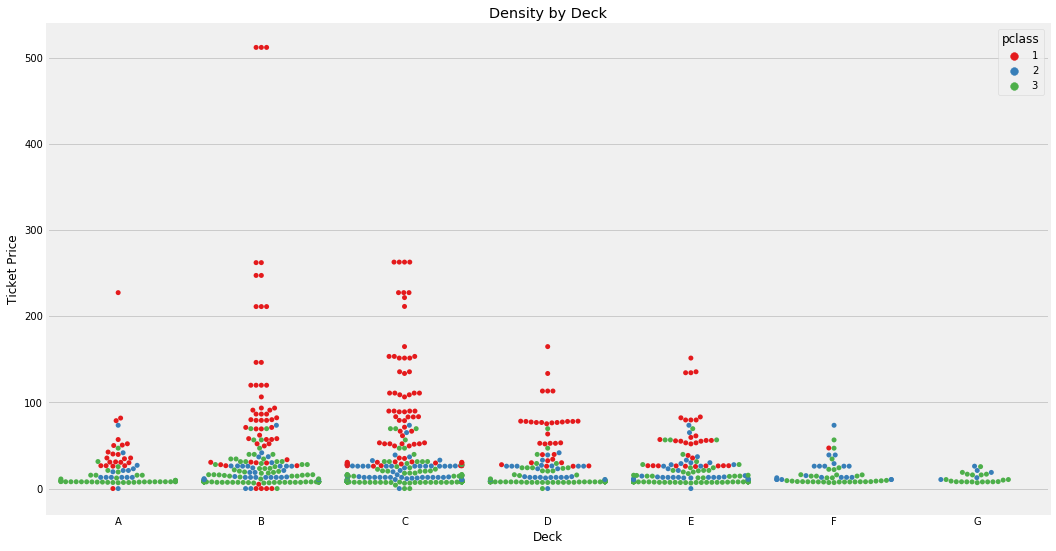

In [94]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
sns.swarmplot(x="deck", y="fare", hue="pclass", data=dft, palette='Set1')

plt.title("Density by Deck")
plt.ylabel("Ticket Price")
plt.xlabel("Deck")

**Finding the anomalies**
> Some deck level B's didn't pay that much for their tickets... Why?  
> Let's look into the 'A' ticket  
> 500 dollar tickets...

In [74]:
deck_estimate = pd.crosstab(dft.pclass, dft.deck)

Text(0.5, 63.5, 'Deck')

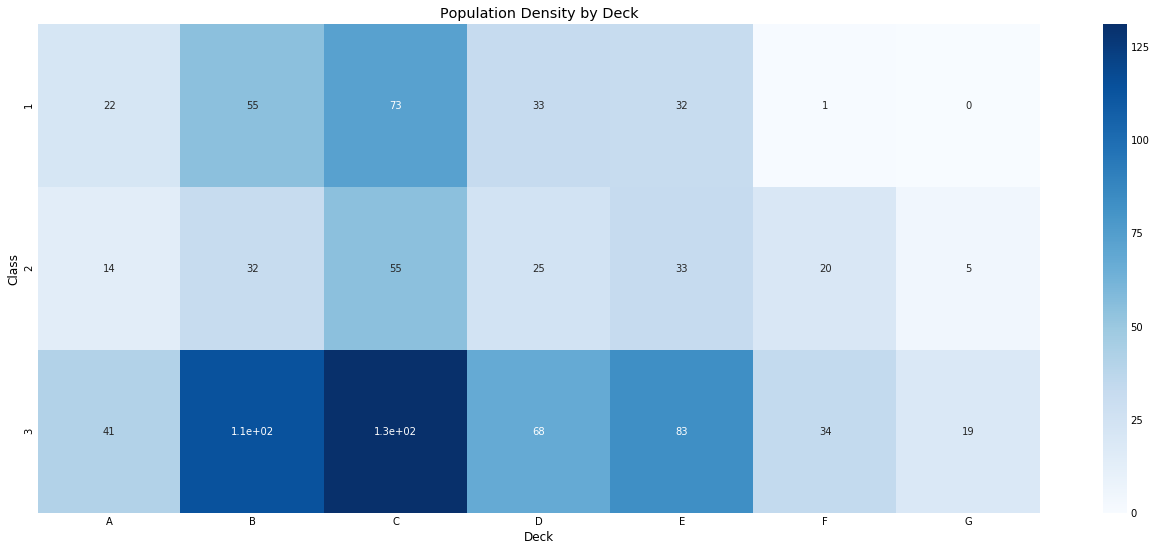

In [75]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 9)

sns.heatmap(deck_estimate, cmap="Blues", annot=True)
plt.title("Population Density by Deck")
plt.ylabel("Class")
plt.xlabel("Deck")

In [76]:
dft['deck'] = dft['deck'].astype('category')
dft['deck_cat'] = dft['deck'].cat.codes

In [55]:
titanic_anom = dft[['deck_cat', 'fare', 'age']]

In [56]:
np_array = titanic_anom.values.astype("float32", copy = False)
stscaler = StandardScaler().fit(np_array)
np_array = stscaler.transform(np_array)

In [57]:
dbsc = DBSCAN(eps = .75, min_samples = 15).fit(np_array)

In [58]:
labels = dbsc.labels_

titanic_anom['labels'] = labels
titanic_anom.labels.value_counts()

 0    833
-1     58
Name: labels, dtype: int64

In [59]:
titanic_anom[titanic_anom.labels == -1].head()

,deck_cat,fare,age,labels
27,2,263.0000,19.0,-1
31,1,146.5208,40.0,-1
54,1,61.9792,65.0,-1
88,2,263.0000,23.0,-1
96,0,34.6542,71.0,-1


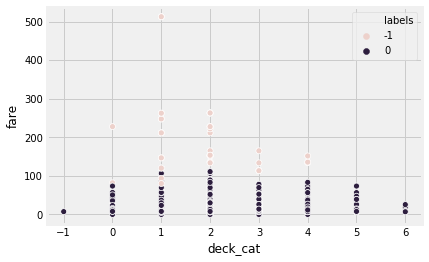

In [60]:
sns.scatterplot(titanic_anom.deck_cat, titanic_anom.fare, hue=titanic_anom.labels)
plt.show()

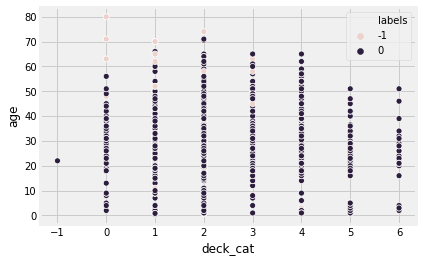

In [61]:
sns.scatterplot(titanic_anom.deck_cat, titanic_anom.age, hue=titanic_anom.labels)
plt.show()

Text(0.5, 0, 'Fare')

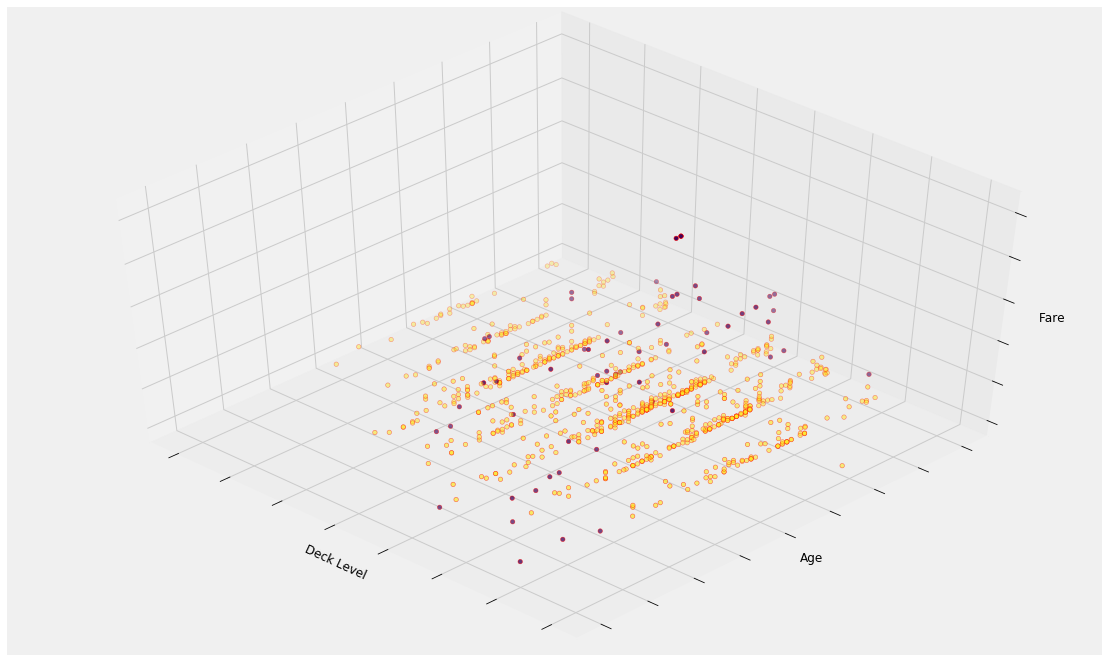

In [64]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(16, 9))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(titanic_anom.deck_cat, titanic_anom.age, titanic_anom.fare,
           c=titanic_anom.labels, edgecolor='r')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Deck Level')
ax.set_ylabel('Age')
ax.set_zlabel('Fare')

# Extra (Zillow Dataset)